In [1]:
#ENV["JULIA_CUDA_MEMORY_LIMIT"] = 10^10 

In [2]:
using CUDA; 
using Knet
using MLDatasets
using LinearAlgebra
using PyPlot
include("resnet34_new.jl")

ResNet34 (generic function with 1 method)

In [3]:
function loss_contrastive(model, x)
    
    LARGE_NUM = 1e9
    temperature = 1.0
    weights = 1.0
    
    z = model(x)
    
    z = transpose(z)
    
    _atype = KnetArray{Float32}
    
    norm_z = sqrt.(sum(abs2,z,dims=2))
    
    zx = z ./ norm_z

    
    bs = size(zx)[1]÷2
    z1 = zx[1:bs,:]
    z2 = zx[bs+1:bs*2,:]
    
    n = size(z1)[1]
    
    #labels = Array{Float64}(I, n, n*2)
    #mask = Array{Float64}(I, n, n)*LARGE_NUM
    labels = convert(_atype, Array{Float64}(I, n, n*2))
    mask = convert(_atype, Array{Float64}(I, n, n)*LARGE_NUM)

    logits_aa = z1*transpose(z1) - mask
    logits_bb = z2*transpose(z2) - mask
    logits_ab = z1*transpose(z2)
    logits_ba = z2*transpose(z1)
    
    loss_a = sum(-labels.*logsoftmax([logits_ab logits_aa], dims=2))/n
    loss_b = sum(-labels.*logsoftmax([logits_ba logits_bb], dims=2))/n
    
    loss = loss_a + loss_b
    
    loss
end

loss_contrastive (generic function with 1 method)

In [4]:
Array{Float64}(I, 3, 3*2)

3×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0

In [5]:
function load_cifar_dataset(bsize)
    xtrn,ytrn = CIFAR10.traindata(Float32);
    xtrn = permutedims(xtrn, (2, 1, 3, 4));
    xtst,ytst = CIFAR10.testdata(Float32);
    xtst = permutedims(xtst, (2, 1, 3, 4));
    println("Loaded CIFAR Data:")
    println.(summary.((xtrn,ytrn,xtst,ytst)))
    dtrn = minibatch(xtrn, (ytrn .+ 1), bsize, xsize=(size(xtrn)[1], size(xtrn)[2], 3, bsize))
    dtst = minibatch(xtst, (ytst .+ 1), bsize, xsize=(size(xtrn)[1], size(xtrn)[2], 3, bsize*4))
    println("Generated minibatches")
    println.(summary.((dtrn, ytrn)))
    dtrn, dtst
end

load_cifar_dataset (generic function with 1 method)

In [6]:
bsize = 16
dtrn, dtst = load_cifar_dataset(bsize);
#model = ResNet34(pretrained=false, in_channels=3, out_channels=10)

Loaded CIFAR Data:
32×32×3×50000 Array{Float32,4}
50000-element Array{Int64,1}
32×32×3×10000 Array{Float32,4}
10000-element Array{Int64,1}
Generated minibatches
3125-element Knet.Train20.Data{Tuple{KnetArray{Float32,N} where N,Array{Int64,N} where N}}
50000-element Array{Int64,1}


In [7]:
model = ResNet34(pretrained=false, in_channels=3, out_channels=10)

SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯])]), identity), BasicB

In [8]:
for p in params(model)
    p.opt = Adam(lr=0.001)
end

In [9]:
epochs = 10
train_loss = zeros(epochs);

In [10]:
for i in 1:epochs
    println("Epoch ", i)
    train_loss[i] = 0.0
    batch_count = 0
    for (x, y) in dtrn
        loss = @diff loss_contrastive(model, x)
        train_loss[i] += value(loss)
        batch_count += 1
        for p in params(model)
            g = grad(loss, p)
            update!(value(p), g, p.opt)
        end
    end
    train_loss[i] /= batch_count
    println("Train epoch loss: ", train_loss[i])
    #GC.gc()
end

Epoch 1
Train epoch loss: 5.432197832489014
Epoch 2
Train epoch loss: 5.423302403259277
Epoch 3
Train epoch loss: 5.420123283081055
Epoch 4
Train epoch loss: 5.4193838665771485
Epoch 5
Train epoch loss: 5.418172606506348
Epoch 6
Train epoch loss: 5.417690656280517
Epoch 7
Train epoch loss: 5.417479390869141
Epoch 8
Train epoch loss: 5.417600724334717
Epoch 9
Train epoch loss: 5.4176634886169435
Epoch 10
Train epoch loss: 5.417056162567139


In [11]:
GC.gc()

In [12]:
CUDA.memory_status()

Effective GPU memory usage: 87.35% (13.888 GiB/15.899 GiB)
CUDA allocator usage: 13.077 GiB
binned usage: 13.077 GiB (431.286 MiB allocated, 12.656 GiB cached)


In [13]:
image = []

Any[]

In [14]:
for (x, y) in dtrn
    image = x
    break
    return image
end

In [15]:
image1 = convert(Array, image[:,:,:,5]);

In [16]:
#image1 = convert(Array, image[:,:,:,5]);
#image1 = permutedims(image1, (2, 1, 3));

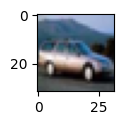

PyObject <matplotlib.image.AxesImage object at 0x7f10d83c0c10>

In [17]:
plt.figure(figsize=(1,1))
plt.imshow(image1)